In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from scipy.stats import ttest_ind
import gripql

In [2]:
conn = gripql.Connection("https://bmeg.io/api", credential_file="/tmp/bmeg_credentials.json")
O = conn.graph("bmeg_rc1_2")

In [3]:
PROJECT="Project:TCGA-LUAD"

In [4]:
c = O.query().V(PROJECT).in_("InProject").in_("SampleFor").as_("sample")
c = c.has(gripql.eq("gdc_attributes.sample_type", "Solid Tissue Normal"))
c = c.in_("AliquotFor").in_("GeneExpressionOf").as_("exp")
c = c.render( ["$sample._data.gdc_attributes.submitter_id", "$exp._data.values"])
data = {}
for row in c.execute(stream=True):
    data[row[0]] = row[1]
normalDF = pandas.DataFrame(data).transpose()

[INFO]	2019-03-11 15:54:00,433	59 results received in 33 seconds


In [5]:
c = O.query().V(PROJECT).in_("InProject").in_("SampleFor").as_("sample")
c = c.has(gripql.eq("gdc_attributes.sample_type", "Primary Tumor"))
c = c.in_("AliquotFor").in_("GeneExpressionOf").as_("exp")
c = c.render( ["$sample._data.gdc_attributes.submitter_id", "$exp._data.values"])
data = {}
for row in c.execute(stream=True):
    data[row[0]] = row[1]
tumorDF = pandas.DataFrame(data).transpose()

[INFO]	2019-03-11 15:58:22,223	539 results received in 260 seconds


In [6]:
stats = {}
for gene in tumorDF:
    s = ttest_ind(tumorDF[gene], normalDF[gene])
    stats[gene] = { 'statistic': s.statistic, 'pvalue' : s.pvalue }
statsDF = pandas.DataFrame(stats).transpose()

In [14]:
statsDF[ statsDF['pvalue'] < 0.0001 ].sort_values('statistic').head()

,pvalue,statistic
ENSG00000168484,3.468274e-227,-53.424128
ENSG00000135604,3.129967e-208,-48.760390
ENSG00000204305,1.240590e-197,-46.265977
ENSG00000114854,1.806339e-188,-44.169569
ENSG00000234281,7.387628e-170,-40.068918


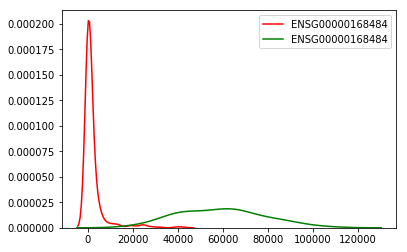

In [8]:
sns.kdeplot(tumorDF['ENSG00000168484'], color="r")
sns.kdeplot(normalDF['ENSG00000168484'], color="g")

In [13]:
for row in O.query().V("ENSG00000168484").in_("GeneOntologyAnnotation"):
    print(row.gid, row.data.definition)

[INFO]	2019-03-11 16:19:51,113	10 results received in 0 seconds


GO:0005515 Interacting selectively and non-covalently with any protein or protein complex (a complex of two or more proteins that may include other nonprotein molecules).
GO:0005576 The space external to the outermost structure of a cell. For cells without external protective or external encapsulating structures this refers to space outside of the plasma membrane. This term covers the host cell environment outside an intracellular parasite.
GO:0005615 That part of a multicellular organism outside the cells proper, usually taken to be outside the plasma membranes, and occupied by fluid.
GO:0097486 The volume enclosed by the outermost membrane of a multivesicular body.
GO:0045334 A clathrin-coated, membrane-bounded intracellular vesicle formed by invagination of the plasma membrane around an extracellular substance.
GO:0042802 Interacting selectively and non-covalently with an identical protein or proteins.
GO:0005789 The lipid bilayer surrounding the endoplasmic reticulum.
GO:0007585 Th